In [122]:
global file
file = input('Selet a folder') ##enter your file path here - the file is in the repo "summary_stats.csv".
raw_file = file
##file

In [123]:
from datetime import datetime
from datetime import date
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import math
import pandas as pd
import  os as os
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt

In [156]:
sg = Subgrounds()
snapshot = sg.load_api('https://hub.snapshot.org/graphql')

In [157]:
snapshot.Proposal.datetime = SyntheticField(
  lambda timestamp: str(datetime.fromtimestamp(timestamp)),
  SyntheticField.STRING,
  snapshot.Proposal.end,
)

In [158]:
spacename = input('spacename plz?')
proposals = snapshot.Query.proposals(
  orderBy='created',
  orderDirection='desc',
  first=10000,
  where=[
    snapshot.Proposal.space == spacename, ##'fuse.eth',
    snapshot.Proposal.state == 'closed'
    ##snapshot.Proposal.title == 'OIP-18: Reward rate framework and reduction',
  ]
)

In [159]:
proposals_snapshots = sg.query_df([
    proposals.title,
    proposals.id,
    proposals.body,
    proposals.scores,
    proposals.scores_total
])

In [160]:
proposals_choices = sg.query(proposals.choices)

In [161]:
proposals_choices = pd.DataFrame(proposals_choices)

In [162]:
olympus_governance_view = pd.concat([proposals_snapshots,proposals_choices], axis=1)

In [163]:
olympus_governance_view

,proposals_title,proposals_id,proposals_body,proposals_scores,proposals_scores_total,0,1,2,3,4,5,6
0,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,**Summary:**\n\nGrant Policy Authority to:\nCo...,7.511731,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
1,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,**Summary:**\n\nGrant Policy Authority to:\nCo...,359883.231566,359890.743297,For: Deploy Bond Protocol,Against: Do nothing,None,None,None,None,None
2,OIP-104: Deploy Permissionless OP as Bond Prot...,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,#### Summary\nDeploy the new system of Permiss...,292512.593605,296088.544685,For: In support of proposal,Against: Not in support,None,None,None,None,None
3,OIP-104: Deploy Permissionless OP as Bond Prot...,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,#### Summary\nDeploy the new system of Permiss...,3575.951080,296088.544685,Approve $50k Grant to Artemis,Reject,None,None,None,None,None
4,OIP-103 Balancer Migration,0xebd05bd5896c472eecceb380b345689fc5afcd295865...,**Summary**\n\nDesignate Balancer as the platf...,322598.605158,322598.605158,For,Against,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
460,Add DAI Bonds,QmUC5xa4YaWZBV7fy241svBQ8bHSMksm8kB7avk1WyWv9m,Summary: We can launch bonds using DAI instead...,7.353389,26630.139267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
461,Add DAI Bonds,QmUC5xa4YaWZBV7fy241svBQ8bHSMksm8kB7avk1WyWv9m,Summary: We can launch bonds using DAI instead...,0.000000,26630.139267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
462,Open an OHM-ETH Pool on Uniswap,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,Summary:\nSeveral community members have broug...,177.543607,20614.265541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
463,Open an OHM-ETH Pool on Uniswap,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,Summary:\nSeveral community members have broug...,0.000000,20614.265541,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
##let's view the output just to make sure
olympus_governance_view

,proposals_title,proposals_id,proposals_body,proposals_scores,proposals_scores_total,0,1,2,3,4,5,6
0,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,**Summary:**\n\nGrant Policy Authority to:\nCo...,7.511731,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
1,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,**Summary:**\n\nGrant Policy Authority to:\nCo...,359883.231566,359890.743297,For: Deploy Bond Protocol,Against: Do nothing,None,None,None,None,None
2,OIP-104: Deploy Permissionless OP as Bond Prot...,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,#### Summary\nDeploy the new system of Permiss...,292512.593605,296088.544685,For: In support of proposal,Against: Not in support,None,None,None,None,None
3,OIP-104: Deploy Permissionless OP as Bond Prot...,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,#### Summary\nDeploy the new system of Permiss...,3575.951080,296088.544685,Approve $50k Grant to Artemis,Reject,None,None,None,None,None
4,OIP-103 Balancer Migration,0xebd05bd5896c472eecceb380b345689fc5afcd295865...,**Summary**\n\nDesignate Balancer as the platf...,322598.605158,322598.605158,For,Against,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
460,Add DAI Bonds,QmUC5xa4YaWZBV7fy241svBQ8bHSMksm8kB7avk1WyWv9m,Summary: We can launch bonds using DAI instead...,7.353389,26630.139267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
461,Add DAI Bonds,QmUC5xa4YaWZBV7fy241svBQ8bHSMksm8kB7avk1WyWv9m,Summary: We can launch bonds using DAI instead...,0.000000,26630.139267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
462,Open an OHM-ETH Pool on Uniswap,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,Summary:\nSeveral community members have broug...,177.543607,20614.265541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
463,Open an OHM-ETH Pool on Uniswap,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,Summary:\nSeveral community members have broug...,0.000000,20614.265541,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
olympus_governance_view_clean = olympus_governance_view.copy(deep=True)
olympus_governance_view_clean.insert(0, 'DAO', spacename)
olympus_governance_view_clean

,DAO,proposals_title,proposals_id,proposals_body,proposals_scores,proposals_scores_total,0,1,2,3,4,5,6
0,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,**Summary:**\n\nGrant Policy Authority to:\nCo...,7.511731,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
1,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,**Summary:**\n\nGrant Policy Authority to:\nCo...,359883.231566,359890.743297,For: Deploy Bond Protocol,Against: Do nothing,None,None,None,None,None
2,olympusdao.eth,OIP-104: Deploy Permissionless OP as Bond Prot...,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,#### Summary\nDeploy the new system of Permiss...,292512.593605,296088.544685,For: In support of proposal,Against: Not in support,None,None,None,None,None
3,olympusdao.eth,OIP-104: Deploy Permissionless OP as Bond Prot...,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,#### Summary\nDeploy the new system of Permiss...,3575.951080,296088.544685,Approve $50k Grant to Artemis,Reject,None,None,None,None,None
4,olympusdao.eth,OIP-103 Balancer Migration,0xebd05bd5896c472eecceb380b345689fc5afcd295865...,**Summary**\n\nDesignate Balancer as the platf...,322598.605158,322598.605158,For,Against,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,olympusdao.eth,Add DAI Bonds,QmUC5xa4YaWZBV7fy241svBQ8bHSMksm8kB7avk1WyWv9m,Summary: We can launch bonds using DAI instead...,7.353389,26630.139267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
461,olympusdao.eth,Add DAI Bonds,QmUC5xa4YaWZBV7fy241svBQ8bHSMksm8kB7avk1WyWv9m,Summary: We can launch bonds using DAI instead...,0.000000,26630.139267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
462,olympusdao.eth,Open an OHM-ETH Pool on Uniswap,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,Summary:\nSeveral community members have broug...,177.543607,20614.265541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
463,olympusdao.eth,Open an OHM-ETH Pool on Uniswap,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,Summary:\nSeveral community members have broug...,0.000000,20614.265541,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
path =file+'/'+spacename+'_proposals_table_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view))+'_proposals.csv'
olympus_governance_view.to_csv(path, index = False)

In [167]:
total_proposals = len(olympus_governance_view)
total_proposals

465

In [168]:
proposal_id = olympus_governance_view.iloc[0,1]

In [169]:
print(proposal_id)

0xe6233a0b159f58a97ba41019bd09cb904bd0120f656dcaac3c7aa33d862abf72


In [170]:

vote_tracker = snapshot.Query.votes(
orderBy = 'created',
orderDirection='desc',
first=10000,
where=[
  snapshot.Vote.proposal == proposal_id
]
)

In [171]:
voting_snapshots_list = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
])

In [172]:
voting_snapshots_list

,votes_id,votes_voter,votes_created,votes_choice,votes_vp
0,bafkreih44a44m4ej2loni54bjgzz2nmbfc2lit324hiqh...,0xCc0002972d604DceD87f079306ad6a555C9Fe122,1658759354,2,376.437434
1,0x473f04dd52469588cc54a10017482b98ce083ff1eb0d...,0xd8929472A97db29867fE5C6F18922c24F59A7A71,1658757220,2,1057.429981
2,0xbe37fd97164f24b6ee13f4b633ad3ff9413493c5069c...,0xBDbFdf3e82fC9d2bE1352e252aB1Ce2287fC2122,1658755919,2,87.229162
3,0x121f54a30024ec4166d1ac4449a3d8293bf4a85d6753...,0x903A97385f13597ea34e1952C6B50D303498FceB,1658753952,2,435.343234
4,0xbbafaefe287c9ce99473382b0b11356d8e8dbb4f9de7...,0x627D5Ed9d7b2EC21a785aB4C560492B3eB65fB3f,1658753659,2,84.418999
...,...,...,...,...,...
112,bafkreieq3vfnro7pspk2m53eg2bacmmmy4ttw5w4hxr5v...,0x6Fbc794c8FE80ba45B6398c54402dc1E167F1572,1658428102,2,317.437320
113,0xfc5b5b03ea7784ad1245f4f1503768186592bed8160d...,0x0199bE12d6F574DB4A55b061653BeC89bFF62aF7,1658427939,2,323.369849
114,bafkreicqpuswkucns5vcspnixuwu4hx6dqhxu6ucpx3yp...,0x55B58545C37a23Ab68eB380116aaCE5eaF7FF564,1658427862,2,340.931001
115,0x812aa20fa9e6144646a93305df9806feebccef2c487b...,0xca6aA0576c2ADc79d2c20e6D53c07f590f62932A,1658427581,2,8671.132415


In [173]:
voting_snapshots_list['Proposal'] = proposal_id
proposal_id

'0xe6233a0b159f58a97ba41019bd09cb904bd0120f656dcaac3c7aa33d862abf72'

In [174]:
x=0
while x <total_proposals:
    proposal_id = olympus_governance_view.iloc[x,1]

    vote_tracker = snapshot.Query.votes(
    orderBy = 'created',
    orderDirection='desc',
    first=10000,
    where=[
      snapshot.Vote.proposal == proposal_id
    ]
    )
    voting_snapshots = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
    ])

    voting_snapshots['Proposal'] = proposal_id
    voting_snapshots_list=pd.concat([voting_snapshots_list, voting_snapshots])

    x=x+1
    progress = 100*(round(x/total_proposals,4))
    ##clear_output(wait=True)
    if progress%5==0:
        print("Progress",progress,"%")

Progress 20.0 %
Progress 40.0 %
Progress 60.0 %
Progress 80.0 %
Progress 100.0 %


In [175]:
len(voting_snapshots_list)

102478

In [176]:
path =file+'/'+spacename+'_voting_snapshots_list_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view))+'.csv'
voting_snapshots_list.to_csv(path, index = False)

In [177]:
governance_data = pd.merge(voting_snapshots_list, olympus_governance_view, how='inner', left_on='Proposal', right_on='proposals_id')
del governance_data["proposals_body"]
governance_data

,votes_id,votes_voter,votes_created,votes_choice,votes_vp,Proposal,proposals_title,proposals_id,proposals_scores,proposals_scores_total,0,1,2,3,4,5,6
0,bafkreih44a44m4ej2loni54bjgzz2nmbfc2lit324hiqh...,0xCc0002972d604DceD87f079306ad6a555C9Fe122,1.658759e+09,2,376.437434,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,7.511731,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
1,bafkreih44a44m4ej2loni54bjgzz2nmbfc2lit324hiqh...,0xCc0002972d604DceD87f079306ad6a555C9Fe122,1.658759e+09,2,376.437434,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,359883.231566,359890.743297,For: Deploy Bond Protocol,Against: Do nothing,None,None,None,None,None
2,0x473f04dd52469588cc54a10017482b98ce083ff1eb0d...,0xd8929472A97db29867fE5C6F18922c24F59A7A71,1.658757e+09,2,1057.429981,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,7.511731,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
3,0x473f04dd52469588cc54a10017482b98ce083ff1eb0d...,0xd8929472A97db29867fE5C6F18922c24F59A7A71,1.658757e+09,2,1057.429981,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,359883.231566,359890.743297,For: Deploy Bond Protocol,Against: Do nothing,None,None,None,None,None
4,0xbe37fd97164f24b6ee13f4b633ad3ff9413493c5069c...,0xBDbFdf3e82fC9d2bE1352e252aB1Ce2287fC2122,1.658756e+09,2,87.229162,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,7.511731,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242780,QmXPL7fViDQBjbg4EikDftXtTwht1sSUYVtHcgrzU3WrUy,0x3942Ae3782FbD658CC19A8Db602D937baF7CB57A,1.617555e+09,{'1': 1},94.118185,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,Open an OHM-ETH Pool on Uniswap,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0.000000,20614.265541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242781,QmXPL7fViDQBjbg4EikDftXtTwht1sSUYVtHcgrzU3WrUy,0x3942Ae3782FbD658CC19A8Db602D937baF7CB57A,1.617555e+09,{'1': 1},94.118185,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,Open an OHM-ETH Pool on Uniswap,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,165.462663,20614.265541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242782,QmYwVd9zd2AzAYSBncxeWYnePQQNGTPJiKjywXdKoFpJvv,0x45ADFF324Eb1ac03a6A115dc539052232D4bA980,1.617554e+09,{'1': 1},0.842478,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,Open an OHM-ETH Pool on Uniswap,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,177.543607,20614.265541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242783,QmYwVd9zd2AzAYSBncxeWYnePQQNGTPJiKjywXdKoFpJvv,0x45ADFF324Eb1ac03a6A115dc539052232D4bA980,1.617554e+09,{'1': 1},0.842478,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,Open an OHM-ETH Pool on Uniswap,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0.000000,20614.265541,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
final_file = file+'\\'+'final'
final_raw_file = final_file

In [179]:
os.makedirs(final_raw_file, exist_ok=True)

In [180]:
final_path =file+'\\'+spacename+'governance_data_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(governance_data))+'.csv'

In [181]:
governance_data.to_csv(final_path, index = False)

In [182]:
crunch_data = db.query("select "
                           "Proposal"
                           ",votes_voter "
                           ",votes_choice"
                           ",votes_vp"
                           ",votes_created"
                           ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                           ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                           ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentange_of_total_vp "
                           ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentange_of_total_vp "
                       ",round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentange_of_total_vp_stepped "
                           ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                           ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) voters_counted "
                           ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                           ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                       "from "
                       "    governance_data  "
                       ""
                       "Group by "
                       "    Proposal"
                       "    ,votes_voter"
                       "    ,votes_choice"
                       "    , votes_vp "
                       "    , votes_created "
                       ""
                       "Order by "
                       "    Proposal, "
                       "    votes_vp desc "
                       "    , votes_created asc"
                       "").df()


crunch_data.insert(0, 'DAO', spacename)
crunch_data.head(n=10)

,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,cumulative_vp,total_vp,percentange_of_total_vp,cum_percentange_of_total_vp,cum_percentange_of_total_vp_stepped,proposal_voter_rank,voters_counted,percentage_voters_counted,percentage_voters_counted_stepped
0,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0x318A11FB434333DE60B3585428CC888eA1E22C67,1,8057.904205,1.646646e+09,8057.904205,32409.067455,0.248631,0.248631,0.0,1,1,0.011628,1.0
1,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xED2A18a533c452293934F5c7A55EbAa5c2B6E6D8,1,5399.999679,1.646647e+09,13457.903883,32409.067455,0.166620,0.415251,0.0,2,2,0.023256,2.0
2,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,1,3312.725382,1.646443e+09,16770.629265,32409.067455,0.102216,0.517467,1.0,3,3,0.034884,3.0
3,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0x8dF24569a74E094bf75E17d1F0c238D39B5E17B5,1,1462.390149,1.646619e+09,18233.019414,32409.067455,0.045123,0.562590,1.0,4,4,0.046512,5.0
4,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xA58C5c1D9589d859AB5481bEa3b39A93079A1a57,1,1321.882651,1.646468e+09,19554.902064,32409.067455,0.040787,0.603377,1.0,5,5,0.058140,6.0
5,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xA523A334C8e0E43f09928890064cd75469b3faE7,1,1289.864265,1.646505e+09,20844.766329,32409.067455,0.039799,0.643177,1.0,6,6,0.069767,7.0
6,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xB37E5BC97476E2E980Ff6e22f2AcF0070d38f042,1,1068.692959,1.646549e+09,21913.459287,32409.067455,0.032975,0.676152,1.0,7,7,0.081395,8.0
7,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xcCe02875B22284877ebf08C9e6FdEe319B01702c,1,927.022268,1.646419e+09,22840.481555,32409.067455,0.028604,0.704756,1.0,8,8,0.093023,9.0
8,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0x7672B17D5Eebb7194d57066f86FBcb4e85a7e10E,1,810.035653,1.646704e+09,23650.517208,32409.067455,0.024994,0.729750,1.0,9,9,0.104651,10.0
9,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0x8353A1264A7D8c7DE77a8cd50A58F649A352D7aB,1,759.613668,1.646659e+09,24410.130876,32409.067455,0.023438,0.753188,1.0,10,10,0.116279,12.0


In [183]:
##spit out the file!
crunch_data_path =final_file+'\\'+spacename+'_crunch_data_path'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'

crunch_data.to_csv(crunch_data_path, index = False)

In [184]:
print('done')

done


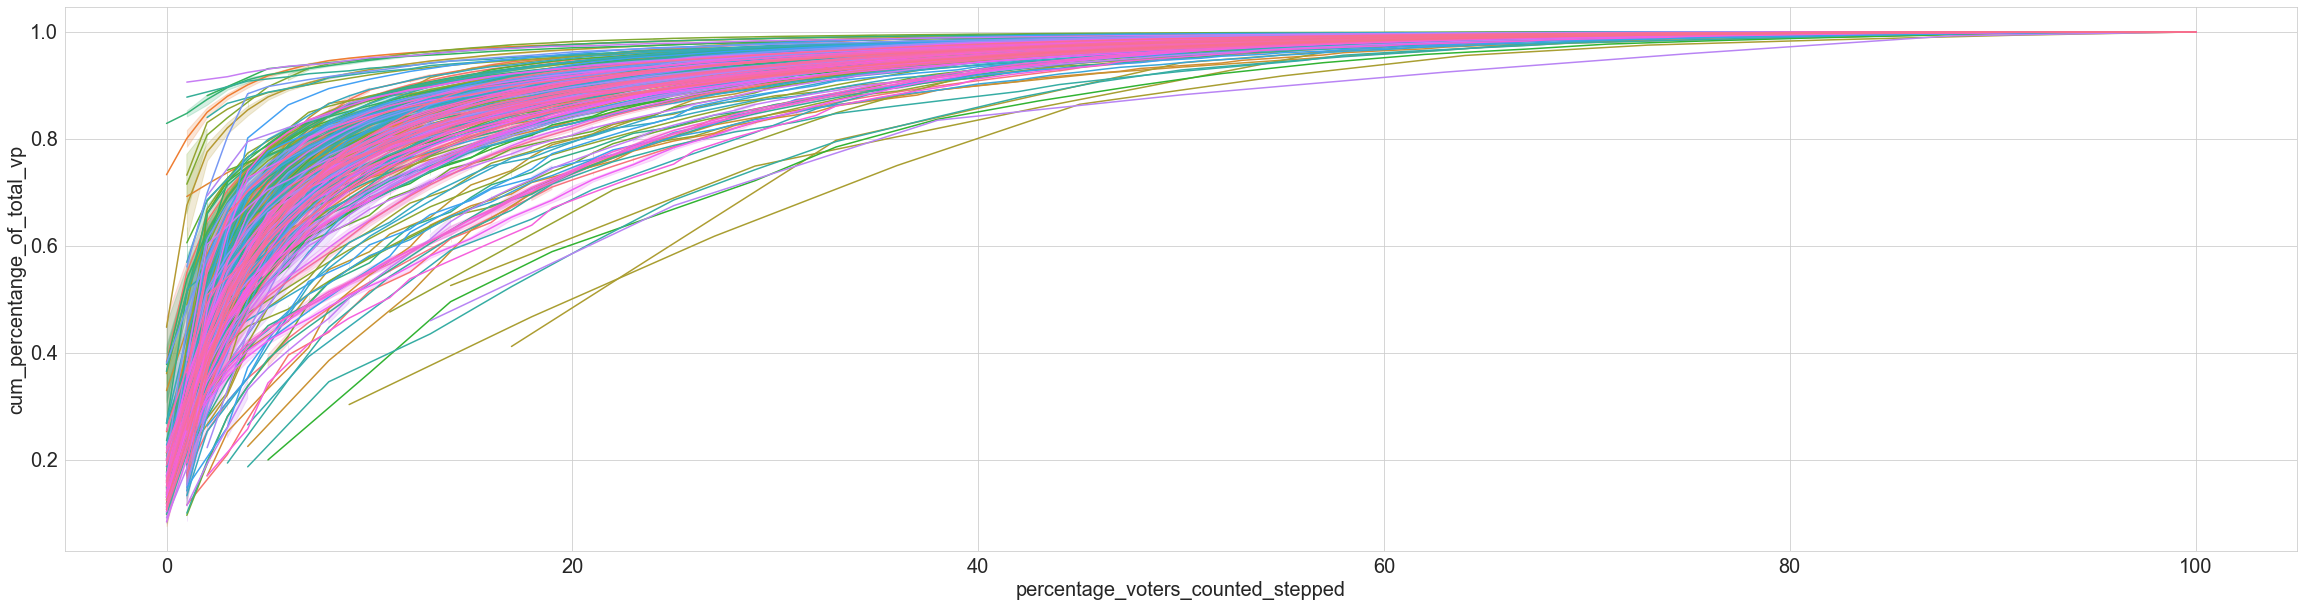

In [185]:
plt.rc("figure", figsize=(40, 10))
plt.rc("font", size=20)

sns.lineplot(data=crunch_data, y="cum_percentange_of_total_vp",x="percentage_voters_counted_stepped", hue="Proposal")
plt.legend([],[], frameon=False)

In [186]:
##sns.boxplot(data=crunch_data, y="cum_percentange_of_total_vp",x="percentage_voters_counted")
##plt.legend([],[], frameon=False)

     percentage_voters_counted_stepped  cum_percentange_of_total_vp
0                                  0.0                     0.202418
1                                  1.0                     0.337749
2                                  2.0                     0.473351
3                                  3.0                     0.554047
4                                  4.0                     0.613534
..                                 ...                          ...
96                                96.0                     0.999960
97                                97.0                     0.999983
98                                98.0                     0.999995
99                                99.0                     0.999999
100                              100.0                     1.000000

[101 rows x 2 columns]


<AxesSubplot:xlabel='percentage_voters_counted_stepped', ylabel='cum_percentange_of_total_vp'>

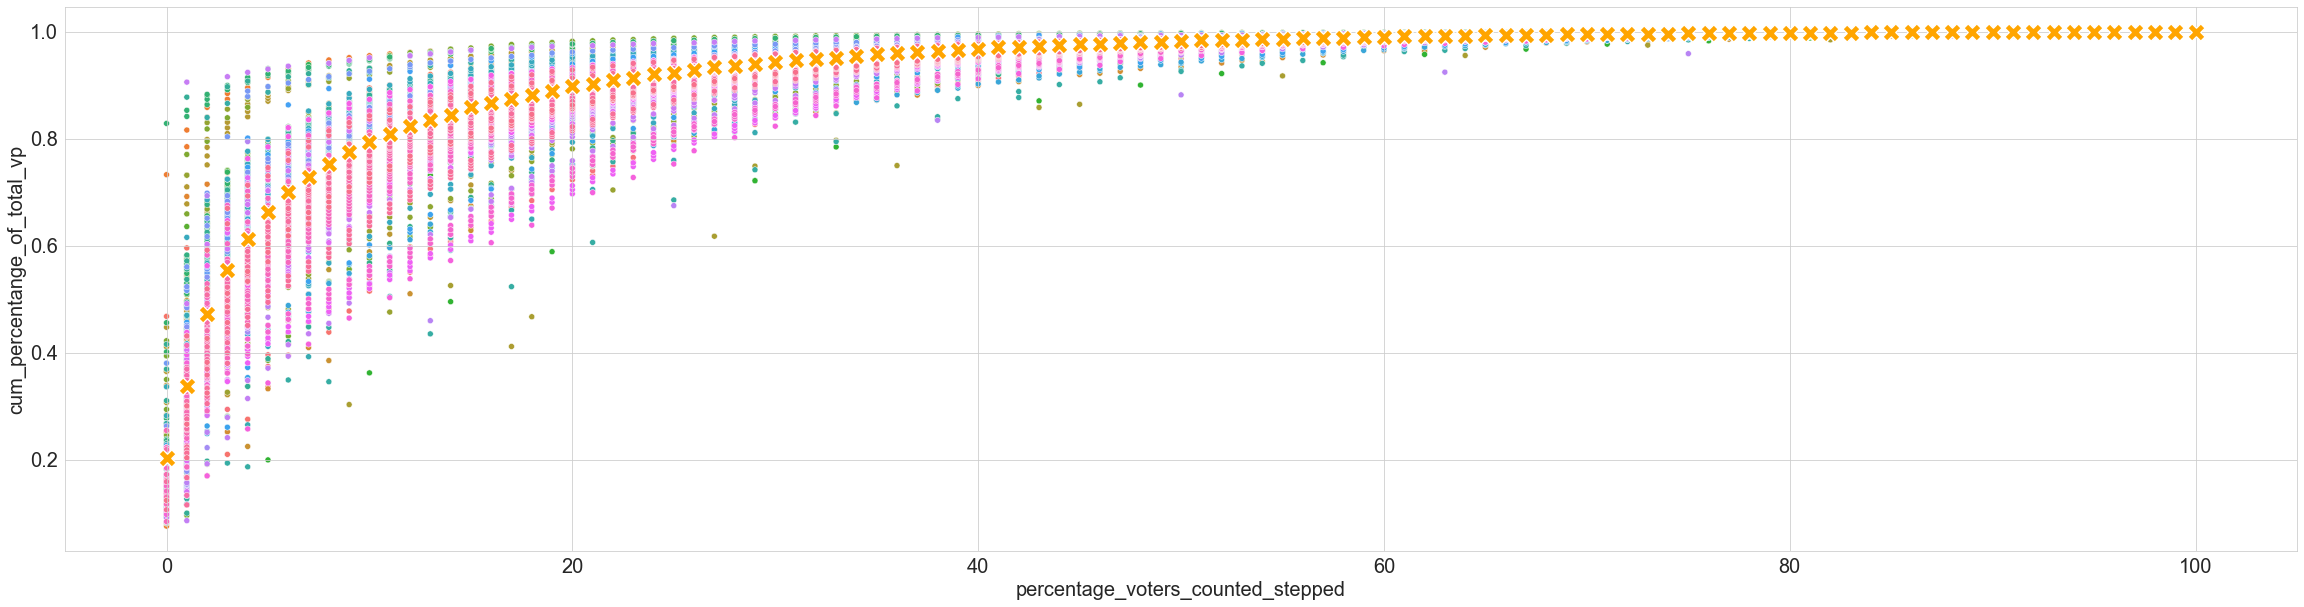

In [187]:
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentange_of_total_vp"].agg("mean").reset_index()
print(data_means)
sns.set_style("whitegrid")
ax=sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentange_of_total_vp", s=300,marker='X',color = 'orange', legend=False)
sns.scatterplot(data=crunch_data, y="cum_percentange_of_total_vp",x="percentage_voters_counted_stepped", hue="Proposal",zorder=-3, legend=False)